___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright by Pierian Data Inc.</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# Q-Learning


Before diving into the topic of **Deep Reinforcement** it is important to get to know the basic concepts of Reinforcement Learning as this allows us to improve our understanding of the whole field.

To do so we take a look at one of the most known classical Reinforcement Learning algorithm called **Q-Learning** and apply this algorithm on the CartPole environment https://gym.openai.com/envs/CartPole-v1/

Let us first take a look at the game and start with the necessary imports

# Part 0 : Imports

In [1]:
%matplotlib notebook

import time  # slow the game down a little bit
from pyglet.window import key  # for manual playing

import gym
import numpy as np  # used for all kinds of matrix / vector operations
import matplotlib.pyplot as plt  # for plotting

# Part 1: Environment Setup

In [2]:
env = gym.make("CartPole-v1")  # We want to solve the CartPole task
env.reset()  # Reset to initial state
for _ in range(100):
    env.render()  # Render on the screen
    action = env.action_space.sample()  # chose a random action
    env.step(action)  # Perform random action on the environment
    time.sleep(0.01)
env.close()  # dont forget to close the environment

C:\Users\VictorHernandez-Urbi\anaconda3\envs\env\lib\site-packages\gym\logger.py:34: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Let us take a look at the possible actions.
You can find them here: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
As we can see, there are 4 observations:
* Cart Position (-4.8 to 4.8)
* Cart Velocity $(-\infty \text{ to } \infty)$
* Pole Angle (-0.418 to 0.418) rad or (-24 to 24) degrees
* Pole Angular Velocity $(-\infty \text{ to } \infty)$

and two actions:
* 0 - Move to the left
* 1 - Move to the right

The next cell contains code to play the game manually - Feel free to try it out by using the left and right arrow key

In [3]:
action = 0
k = 0
def key_press(k, mod):
    '''
    This function gets the key press for gym
    '''
    global action
    if k == key.LEFT:
        action = 0
    if k == key.RIGHT:
        action = 1

env.reset()
rewards = 0
for _ in range(1000):
    env.render()
    env.viewer.window.on_key_press = key_press  # update the key press
    observation, reward, done, info = env.step(action)  # get the reward and the done flag
    rewards+=1
    if done:
        print(f"You got {rewards} points!")
        break
    time.sleep(0.5)  # reduce speed a little bit (edit as needed on you computer)
env.close()


You got 11 points!


# Part 2:
# Discretization for Q Table

We need to solve one problem before we can start working on the implementation:
The Q-Learning algorithm relies on the creation of discrete Q-Tables but our environment returns continuous values (angle and velocity).
So we need to discretize our observation, i.e we assign each observation to a discrete state.
To do so, we need to define a number of classes for each observation in order to assign each observation to one of those classes.<br />
In fact those classes are called *bins*

Let us just say that we want to allow 10 possible observations, thus each continuous observation is put into one of the 10 bins.
We can use *np.linspace(low, high, num)* for that. <br />
*np.linspace* creates a linearly spaced array from low to high containing num elements (10 in our case). <br />
The values used for low and high are the max value we took from the cartPole source code.(https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py). You can find them above. <br />
For the sake of convenience, we dont use the range $-\infty$ to $\infty$ for the velocity, but -5 to 5.


In [4]:
def create_bins(num_bins_per_action=10):
    bins_cart_position = np.linspace(-4.8, 4.8, num_bins_per_action)  # bins for the cart position
    bins_cart_velocity = np.linspace(-5, 5, num_bins_per_action)  # bins for the cart velocity
    bins_pole_angle = np.linspace(-0.418, 0.418, num_bins_per_action)  # bins for the pole angle
    bins_pole_angular_velocity = np.linspace(-5, 5, num_bins_per_action)  # bins for the pole angular velocity
    bins = np.array([bins_cart_position, bins_cart_velocity, bins_pole_angle, bins_pole_angular_velocity])  # merge them
    return bins

In [5]:
NUM_BINS = 10
BINS = create_bins(NUM_BINS)  # Create the bins used for the rest of the notebook

We now defined our possible bins for each observation. Let's take a look at them:

In [6]:
print(f"Bins for Cart Position: {BINS[0]}")
print(f"Bins for Cart Velocity: {BINS[1]}")
print(f"Bins for Pole Angle: {BINS[2]}")
print(f"Bins for Pole Angular Velocity : {BINS[3]}")

Bins for Cart Position: [-4.8        -3.73333333 -2.66666667 -1.6        -0.53333333  0.53333333
  1.6         2.66666667  3.73333333  4.8       ]
Bins for Cart Velocity: [-5.         -3.88888889 -2.77777778 -1.66666667 -0.55555556  0.55555556
  1.66666667  2.77777778  3.88888889  5.        ]
Bins for Pole Angle: [-0.418      -0.32511111 -0.23222222 -0.13933333 -0.04644444  0.04644444
  0.13933333  0.23222222  0.32511111  0.418     ]
Bins for Pole Angular Velocity : [-5.         -3.88888889 -2.77777778 -1.66666667 -0.55555556  0.55555556
  1.66666667  2.77777778  3.88888889  5.        ]


## Mapping from Continuous to Discrete

------

We now need to write a function which maps each observation to one of those values.
Luckily numpy provides the function *digitize(data, bins)* for us which takes care of the mapping.
*np.digitize()* returns the index of the bin which is closest to the data to be mapped

In [6]:
### Digitize Demo ###
demo_bin = [0, 1, 2, 3, 4, 5]
demo_data = 2.4  # as 2 hast the closest distance to 2.4, the result
                 # of the digitize function should be 3, as 2 is located at the third index of the bins
print(np.digitize(demo_data, demo_bin))

3


In [7]:
def discretize_observation(observations, bins):
    binned_observations = []
    for i, observation in enumerate(observations):
        discretized_observation = np.digitize(observation, bins[i])
        binned_observations.append(discretized_observation)
    return tuple(binned_observations) # Important for later indexing

Let us test our function

In [8]:
observation = env.reset()  # Remember that env.reset() returns the intial observation
print(f"Cart Position: {observation[0]}")
print(f"Cart Velocity: {observation[1]}")
print(f"Pole Angle: {observation[2]}")
print(f"Pole Angular Velocity : {observation[3]}")

Cart Position: 0.019975900299562074
Cart Velocity: -0.02642949023162683
Pole Angle: -0.04505390073892856
Pole Angular Velocity : 0.03839402789678596


In [9]:
mapped_observation = discretize_observation(observation, BINS)
print(mapped_observation)

(5, 5, 5, 5)


(5, 5, 5, 5) means that each observation is assigned to bin 5.
Lets check if that is correct

Bin 5 contains the values 0.53333/0.55555 for all observations which leads to bin 5 for each individual observation! <br />
But another test might be a good idea.
Lets define the array: <br />
test = (-5, 5, 0.2, -4). <br />
If our function works correctly, it should output:(0, 10, 7, 1) as those are the bins corresponding to those values

In [28]:
test = (-5, 5, 0.2, -4)
discretize_observation(test, BINS)  # Nice!

(0, 10, 7, 1)

Now that we validated the functionality of our function it is time to move on with the Q-Learning algorithm. <br />
Let us create the Q-Table:
Remember that the Q-Table has a cell for each permutation of state-action pair. <br />
As there are 4 possible observations, (with 10 bins each) and 2 actions this yields that:
$$10\times10\times10\times10\times2$$ cells are needed to cover all permutations

We can create the Q-Table by using np.zeros(shape)

In [8]:
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)
print(q_table.shape)

(10, 10, 10, 10, 2)


-------
--------
# Constants and Hyperparameters

In [9]:
EPOCHS = 20000
ALPHA = 0.8
GAMMA = 0.9


In [10]:
# Exploration vs. Exploitation parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001             # Exponential decay rate for exploration prob

## Now it is time to dive into the training / Q-Table update methodology.<br />
First we will define some functions needed for training phase

* epsilon_greedy_action_selection: Is used to implement the epsilon greedy action selection routine.
* fail: Defines the lowest amounts of points which actually count as **solved**, otherwise sets the reward to a very small value
* compute_next_q_value: Computes the next Q-Values according to the formula from the lecture
* reduce_epsilon: Reduces the $\epsilon$ used for the epsilon greedy algorithm

In [11]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    '''
    Returns an action for the agent. Note how it uses a random number to decide on
    exploration versus explotation trade-off.
    '''
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:

        action = np.argmax(q_table[discrete_state])

    # EXPLORATION, USE A RANDOM ACTION
    else:
        # Return a random 0,1,2,3 action
        action = np.random.randint(0, env.action_space.n)

    return action

**FUNCTION FOR Q_VALUE COMPUTATION**

**Here we have our main Q-Learning update equation, note how it takes in the old q-value, the next optimal q value, along with our current reward, and then updates the next q value accordingly.**

In [12]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)


**FUNCTION TO REDUCE EPSILON**

**As training continues, we need to balance explotation versus exploration, we want ot make sure our agent doesn't get trapped in a cycle going from an F square to another F Square back and forth. We also don't want our agent permanently choosing random values. We'll use the function below to try to balance this.**

*Note, this is an alternative to our previous exponential decay, its a linear decay. It's not worse or better, just an alternative.*

In [13]:
BURN_IN = 1
epsilon = 1

EPSILON_END= 10000
EPSILON_REDUCE = 0.0001

In [14]:
def reduce_epsilon(epsilon, epoch):
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon-= EPSILON_REDUCE
    return epsilon

**CUSTOM REWARD VALUES**

In [15]:
def fail(done, points, reward):
    if done and points < 150:
        reward = -200
    return reward

## Training

<IPython.core.display.Javascript object>


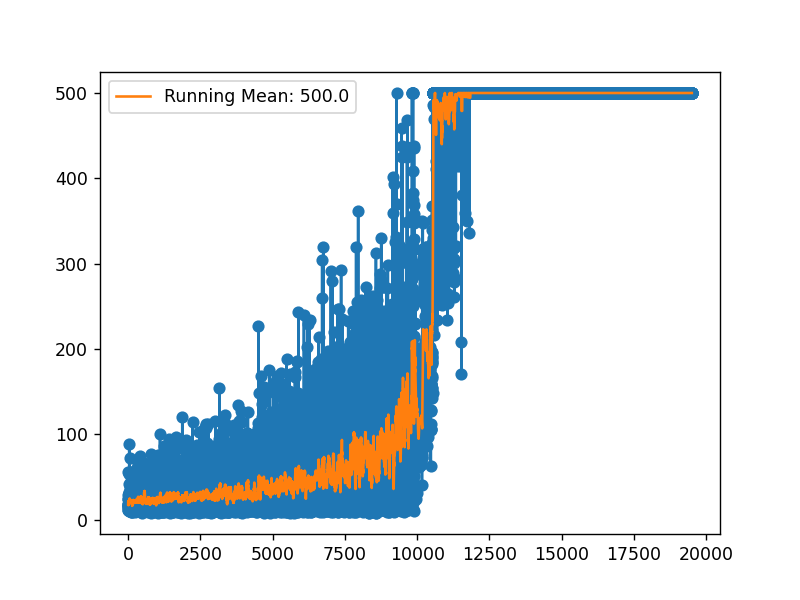

In [16]:
##############################################
### VISUALIZATION OF TRAINING PROGRESS ######
#############################################


log_interval = 500  # How often do we update the plot? (Just for performance reasons)
render_interval = 2000  # How often to render the game during training (If you want to watch your model learning)
### Here we set up the routine for the live plotting of the achieved points ######
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
##############################################
#############################################

points_log = []  # to store all achieved points
mean_points_log = []  # to store a running mean of the last 30 results
epochs = []  # store the epoch for plotting

for epoch in range(EPOCHS):
    
    ## Continuous State --> Discrete State
    
    initial_state = env.reset()  # get the initial observation
    discretized_state = discretize_observation(initial_state, BINS)  # map the observation to the bins
    
    done = False  # to stop current run when cartpole falls down   
    points = 0  # store result
    
    # Track Epochs for Plotting Visualization
    epochs.append(epoch)
    
    
    while not done:  # Perform current run as long as done is False (as long as the cartpole is up)
        
        # View how the cartpole is doing every render interval
#         if epoch % render_interval == 0:  
#             env.render()

        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)  # Epsilon-Greedy Action Selection 
        next_state, reward, done, info = env.step(action)  # perform action and get next state
        reward = fail(done, points, reward)  # Check if reward or fail state


        next_state_discretized = discretize_observation(next_state, BINS)  # map the next observation to the bins

        old_q_value =  q_table[discretized_state + (action,)]  # get the old Q-Value from the Q-Table
        next_optimal_q_value = np.max(q_table[next_state_discretized])  # Get the next optimal Q-Value
        

        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)  # Compute next Q-Value
        q_table[discretized_state + (action,)] = next_q  # Insert next Q-Value into the table

        discretized_state = next_state_discretized  # Update the old state
        points += 1

    epsilon = reduce_epsilon(epsilon, epoch)  # Reduce epsilon
    points_log.append(points)  # log overall achieved points for the current epoch
    running_mean = round(np.mean(points_log[-30:]), 2)  # Compute running mean points over the last 30 epochs
    mean_points_log.append(running_mean)  # and log it
    
    ################ Plot the points and running mean ##################
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, points_log)
        ax.plot(epochs, points_log)
        ax.plot(epochs, mean_points_log, label=f"Running Mean: {running_mean}")
        plt.legend()
        fig.canvas.draw()
  ######################################################################

env.close()


Now it is time for a final evaluation round!
Let's see how well our first RL agent performs

# Final Agent Playing the Game

In [17]:
observation = env.reset()
rewards = 0
for _ in range(1000):
    env.render()
    discrete_state = discretize_observation(observation, BINS)  # get bins
    action = np.argmax(q_table[discrete_state])  # and chose action from the Q-Table
    observation, reward, done, info = env.step(action) # Finally perform the action
    rewards+=1
    if done:
        print(f"You got {rewards} points!")
        break
env.close()


You got 500 points!


Feel free to change all hyperparameters!
Especially the number of bins has a huge impact on the training